## GBSV MC2: Mustererkennung in Bildern und Signalen
Auftrag: Passend zu deinem Land: Definiere einen Anwendungsfall, um zu erkennen, ob ein 1D Signal wiederkehrende Muster enthält. Suche ein 1D Signal, welches wiederkehrende Muster enthält, um Auto-Korrelation anzuwenden. 
Für die MC2 werde ich französisch Polynesien als mein Land wählen, wie bereits in der MC1. Für mein 1D Signal verwende ich eine Tonaufnahme eines Okulele-Liedes. Die Lieder sind in der Regel sehr simpel und nutzen häufig die selben Akkorde, weswegen es möglich sein sollte darin ein wiederkehrendes Signal zu finden.  

In [2]:
#Libraries importieren
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm

In [3]:
df = pd.read_csv("data/boston.csv", index_col=1)

In [4]:
df.describe()
df.head()

,Unnamed: 0,tmax,tmin,prcp
Date,,,,
1872-01-01,1,NaN,NaN,0.00
1872-01-02,2,NaN,NaN,0.00
1872-01-03,3,NaN,NaN,0.00
1872-01-04,4,NaN,NaN,0.73
1872-01-05,5,NaN,NaN,0.00


Wie man im Audiofile hört, scheinen sich die Riffs immer zu wiederholen. Auch das Frequenzdiagramm scheint immer ähnliche Muster zu haben, weswegen ich denke dass vielleicht ein wiederkehrendes Muster gefunden werden kann. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55517 entries, 1872-01-01 to 2023-12-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  55517 non-null  int64  
 1   tmax        55389 non-null  float64
 2   tmin        55395 non-null  float64
 3   prcp        55514 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 2.1+ MB


In [6]:
df = df[['tmax']].copy()
df.dropna()



,tmax
Date,
1872-03-01,31.0
1872-03-02,29.0
1872-03-03,37.0
1872-03-04,40.0
1872-03-05,22.0
...,...
2023-12-27,53.1
2023-12-28,45.0
2023-12-29,46.0


Die Daten stammen von https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488. Die Seite bietet einfach zu nutzende Datensets für Temperaturen für verschiedene U.S. Städte an. Die Temperaturen sind in Fahrenheit, da es hier aber um das Signal und die Veränderung resp. Muster geht rechne ich die Werte nicht in C um.

<Axes: xlabel='Date'>

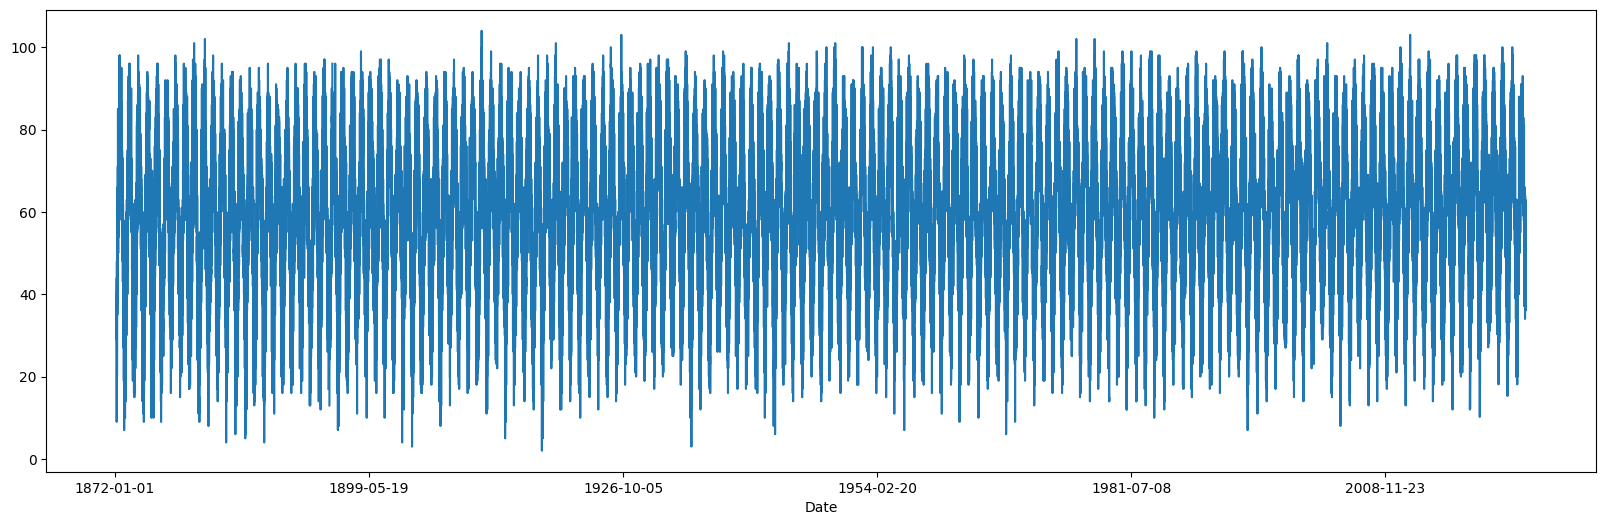

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
df.tmax.plot()

In [8]:
df_last10 = df.iloc[-7300:].dropna()
df_first10 = df.iloc[:7300].dropna()

df_last10.tail()

,tmax
Date,
2023-12-27,53.1
2023-12-28,45.0
2023-12-29,46.0
2023-12-30,46.0
2023-12-31,41.0


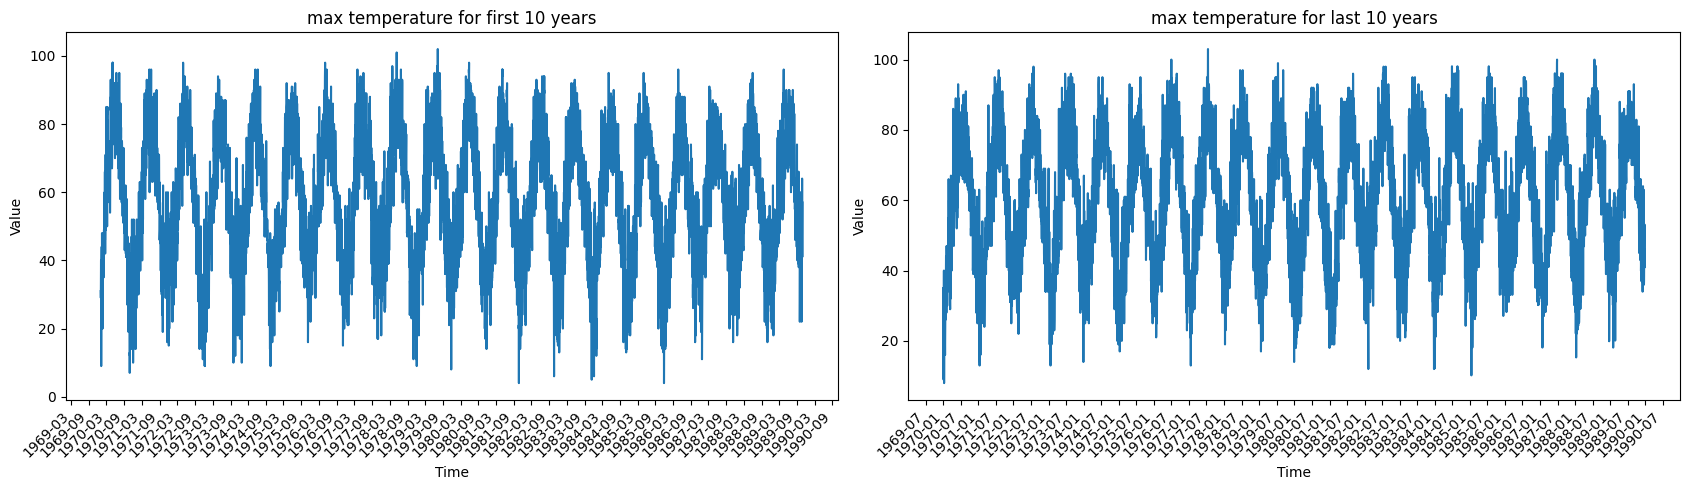

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
import matplotlib.dates as mdates
ax1.plot(df_first10.tmax)
ax1.set_title("max temperature for first 10 years")
ax1.set_xlabel("Time")
ax1.set_ylabel("Value")

# Plot second time series
ax2.plot(df_last10.tmax)
ax2.set_title("max temperature for last 10 years")
ax2.set_xlabel("Time")
ax2.set_ylabel("Value")

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()

<Figure size 3000x600 with 0 Axes>

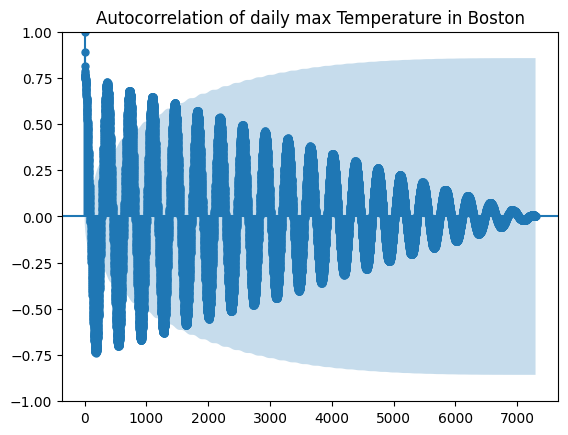

In [10]:
plt.figure(figsize=(30, 6))
sm.graphics.tsa.plot_acf(df_last10, lags = len(df_last10)-1)  
plt.title("Autocorrelation of daily max Temperature in Boston")
plt.show()

Im Korrolellogramm sehen wir sehr deutlich, dass es in Boston saisonale Unterschiede gibt bei den Temperaturen, was du erwarten war. 

<Figure size 3000x600 with 0 Axes>

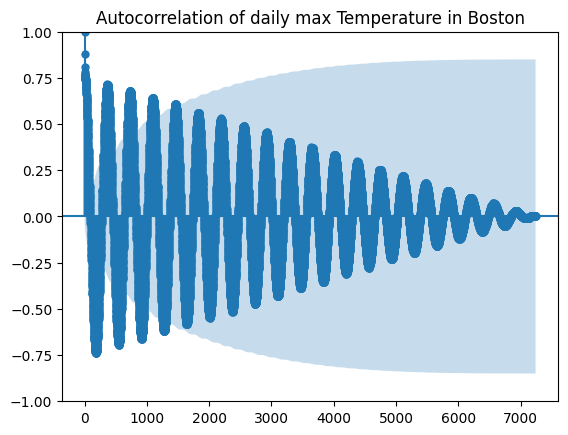

In [11]:
plt.figure(figsize=(30, 6))
sm.graphics.tsa.plot_acf(df_first10, lags = len(df_first10)-1)  
plt.title("Autocorrelation of daily max Temperature in Boston")
plt.show()

Für die Autokorrelation nutze ich nur jeweils 10 Jahre, da das Korrolellogram ansonsten nicht lesbar ist da es zu viele Lags sind. Aus Neugier habe ich die ersten 10 und die letzten 10 Jahre des Dataframe genommen. Die Annahme / Hoffnung war, dass die Korrelationswerte bei den früheren Jahren deutlicher wären da ich annehme dass di Saisonalen unterschiede damals grösser waren. Dem ist aber nicht so. 

## Aufgabe 2: Signal ausschneiden

Usecase: Wir reden immer von Klimawandel und davon, dass die Winter wärmer werden. Es wäre daher vermutlich interessant zu schauen, ob wärmere Winter sich häufen. 
Die beiden Zeitstrahle von den ersten 10 Jahren und letzten 10 Jahren scheinen das auf den ersten Blick nicht zu belegen, da die Kurven recht ähnlich sind. 
Ich versuche daher einen Winter zu finden, der sehr warm war und dann zu schauen, ob das Muster auch in anderen Jahren ersichtlich ist. 
Um einen besonders warmen Winter zu finden, werde ich wie folgt vorgehen:
1. Datensatz um Saison erweitern & eine Spalte für das Winterjahr hinzufügen (damit Dezember, Januar und Februar im selben Jahr liegen)
2. Durchschnittstemperaturen für Wintersaison berechnen 
3. Winter herausfiltern, deren Durchschnittswerte Ausreisser darstellen
4. Diese Winter plotten um sie visuell zu inspizieren
5. einen der Winter als mein Signal aussuchen
    

In [13]:
df.index = pd.to_datetime(df.index)
df['month'] = df.index.month
df['year'] = df.index.year

df['season'] = df.month.apply(lambda x: 'winter' if x in [12, 1, 2] else ('summer' if x in [6, 7, 8] else 'spring/summer'))
df['winteryear'] = df.apply(lambda row: row['year'] - 1 if row['month'] in [1, 2] else row['year'], axis=1)



In [20]:
df.head(14)

,tmax,month,season,year,winteryear
Date,,,,,
1872-01-01,NaN,1,winter,1872,1871
1872-01-02,NaN,1,winter,1872,1871
1872-01-03,NaN,1,winter,1872,1871
1872-01-04,NaN,1,winter,1872,1871
1872-01-05,NaN,1,winter,1872,1871
1872-01-06,NaN,1,winter,1872,1871
1872-01-07,NaN,1,winter,1872,1871
1872-01-08,NaN,1,winter,1872,1871
1872-01-09,NaN,1,winter,1872,1871


season      spring/summer     summer     winter
winteryear                                     
1871                  NaN        NaN        NaN
1872            56.284153  81.717391  32.422222
1873            55.874317  79.652174  37.855556
1874            56.393443  78.326087  33.244444
1875            54.743169  79.206522  37.934066
...                   ...        ...        ...
2019            60.160109  81.414130  44.435165
2020            59.660656  80.867391  38.691111
2021            62.475956  82.115217  41.147778
2022            61.419126  82.722826  43.731111
2023            60.737705  77.878261  47.145161

[153 rows x 3 columns]


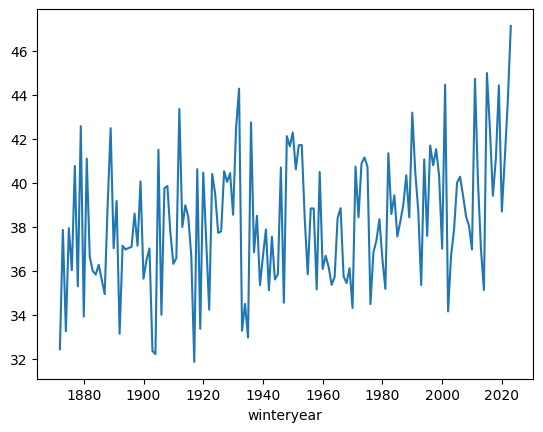

In [24]:
seasonal_avg = df.groupby(['winteryear', 'season'])['tmax'].mean().unstack()
winter_avg = seasonal_avg['winter'].mean()
winter_std = seasonal_avg['winter'].std()

seasonal_avg.winter.plot()

print(seasonal_avg)

In [43]:
winter_avg = seasonal_avg['winter'].mean()
winter_std = seasonal_avg['winter'].std()

warm_winter_years = seasonal_avg[seasonal_avg['winter'] > (winter_avg + winter_std)]
warmest_year = warm_winter_years.loc[warm_winter_years.winter == max(warm_winter_years.winter)]

print(warmest_year)


season      spring/summer     summer     winter
winteryear                                     
2023            60.737705  77.878261  47.145161


Wie im Boxplot ersichtlich gibt es einige sehr warme Winterwerte mit Temperaturen über 70° F (etwa 20° Celsius)
Dafür gibt es auch einige Sommertage mit Werten unter 60° Fahrenheit. Als nächstes filtern wir mal diese Datensätze aus

In [33]:
warm_winter_years

season,spring/summer,summer,winter
winteryear,,,
1879,58.153005,77.554348,42.582418
1889,57.081967,75.554348,42.488889
1905,57.868852,76.804348,41.505618
1912,59.557377,78.902174,43.366667
1931,62.060109,78.815217,42.494505
1932,59.595628,80.173913,44.288889
1936,58.896175,77.626374,42.755556
1948,59.841530,79.413043,42.122222
1949,60.857923,83.456522,41.666667


In [119]:
seasonal_avg = df.groupby(['year', 'season'])['tmax'].mean().unstack()


KeyError: 'year'

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 358 entries, 1873-12-04 to 2023-12-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmax    358 non-null    float64
 1   month   358 non-null    int32  
 2   season  358 non-null    object 
dtypes: float64(1), int32(1), object(1)
memory usage: 9.8+ KB


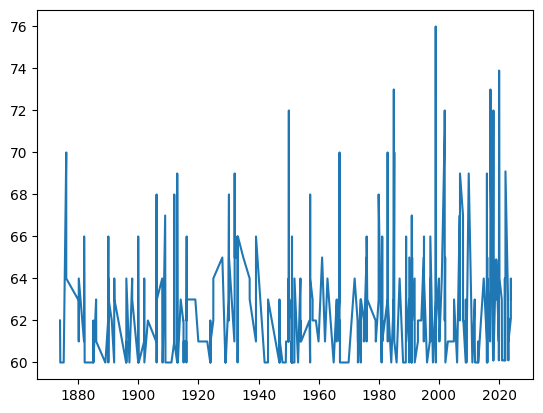

In [97]:
warme_winter = df.loc[(df.tmax >= 60)&(df.season == 'winter')]
warme_winter.info()


plt.plot(warme_winter['tmax'])

In [95]:
kalte_sommer = df.loc[(df.tmax <= 55)&(df.season == 'summer')]
kalte_sommer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73 entries, 1872-06-05 to 2023-06-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmax    73 non-null     float64
 1   month   73 non-null     int32  
 2   season  73 non-null     object 
dtypes: float64(1), int32(1), object(1)
memory usage: 2.0+ KB


<Axes: xlabel='Date'>

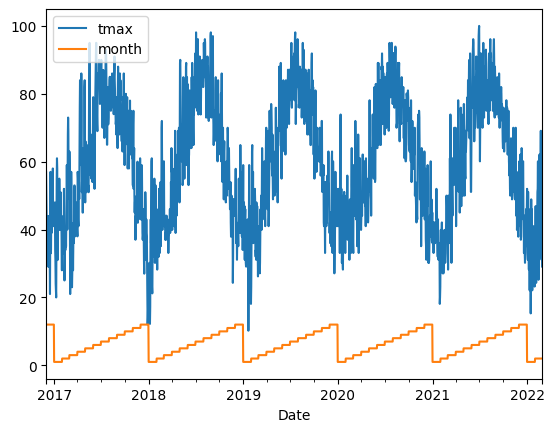

In [109]:
winter_1999 = df.loc['2016-12-01':'2022-02-28']
winter_1999.plot()

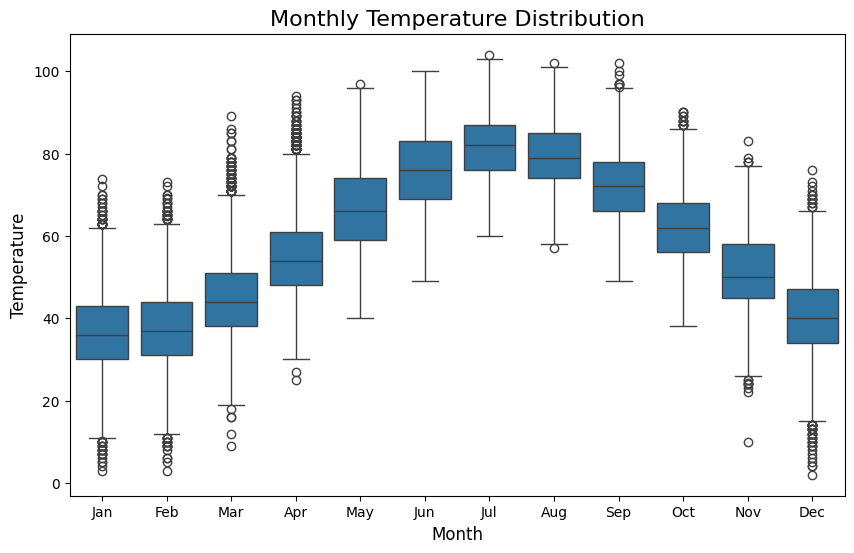

In [112]:
df['month'] = df.index.month

# Plotting with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='tmax', data=df)

# Adding labels and title
plt.title('Monthly Temperature Distribution', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Display the plot
plt.show()

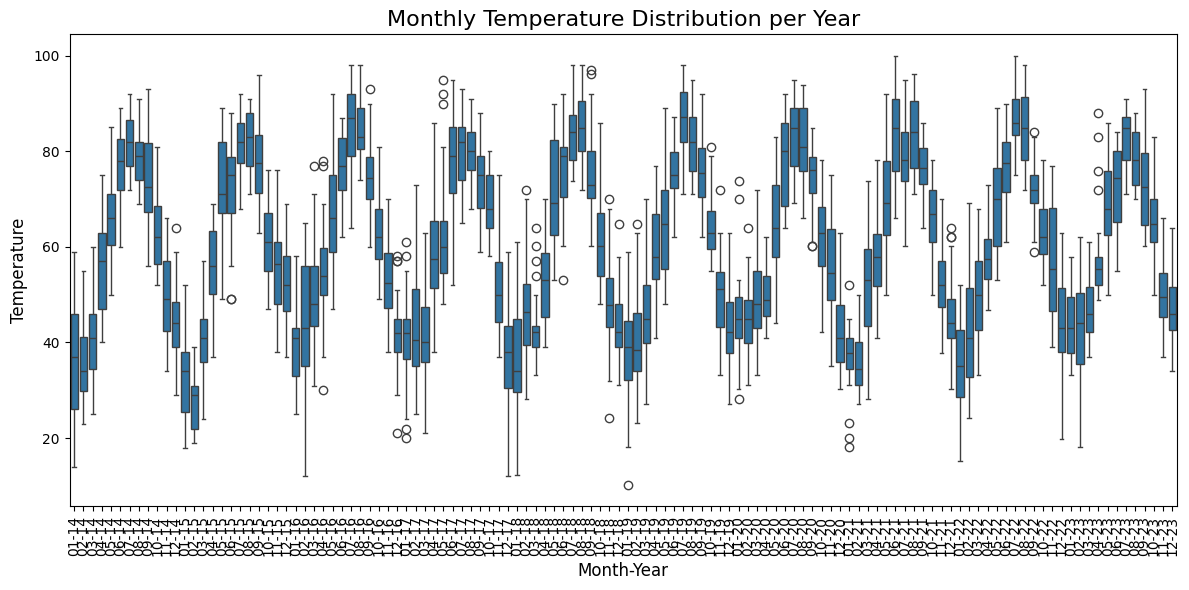

In [115]:
# Create a 'year-month' column (e.g., "01-22", "02-22")
df_last10['year_month'] = df_last10.index.strftime('%m-%y')

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='year_month', y='tmax', data=df_last10)

# Adding labels and title
plt.title('Monthly Temperature Distribution per Year', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

# Display the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # To prevent label clipping
plt.show()